In [31]:
# reload(result_collection.collect_batch_results)
import sys
import importlib

import result_collection
from result_collection.collect_batch_results import *
from result_collection.helper_func import *

importlib.reload(result_collection.helper_func)

# # Given a single experiment result in json format
# # return the average reward R per time step and standard deviation
# # and the similarity to a given comparison policy (assumed TFT)
# # as an average over all repeats
# def get_av_end_R_std_TFT(results, comparison_policy=[[1, 1, 0, 1, 0], [1, 1, 1, 0, 0]], tolerance=0.5):
#     av_R_1, av_R_2, av_compare_1, av_compare_2 = get_end_R_std_compare(results, comparison_policy, tolerance)

#     std_av_reward_1 = np.std(av_R_1)
#     av_R_1 = np.mean(av_R_1)

#     std_av_reward_2 = np.std(av_R_2)
#     av_R_2 = np.mean(av_R_2)

#     av_compare_1 = np.mean(av_compare_1)
#     av_compare_2 = np.mean(av_compare_2)

#     return av_R_1, std_av_reward_1, av_R_2, std_av_reward_2, av_compare_1, av_compare_2


# # Given a single experiment result in json format
# # return the average reward R per time step and standard deviation
# # and the similarity to a given comparison policy (assumed TFT)
# # for each individual repeat
# def get_end_R_std_compare(results, comparison_policy=[[1, 1, 0, 1, 0], [1, 1, 1, 0, 0]], tolerance=0.5):

#     # Get some info about the simulation experiment
#     game = results["config"]["simulation"]["game"]
#     agent_pair = results["config"]["simulation"]["agent_pair"]
#     r1 = np.array(results["config"]["game"]["payoff1"])
#     r2 = np.array(results["config"]["game"]["payoff2"])
#     gamma = results["config"]["agent_pair"]["gamma"]

#     # Metrics to record
#     all_R_1 = []
#     all_R_2 = []
#     all_compare_1 = []
#     all_compare_2 = []

#     for i, experiment in enumerate(results["results"]["seeds"]):
#         end_policy1 = np.array(experiment["P1"])
#         end_policy2 = np.array(experiment["P2"])

#         # Calculated as an absolute difference between end policy and
#         # comparison = 1 - np.mean(np.abs(end_policy - comparison_policy), 1)
        
#         comparison1 = 1 if np.all(np.abs(end_policy1 - np.array(comparison_policy[0])) <= tolerance) else 0
#         comparison2 = 1 if np.all(np.abs(end_policy2 - np.array(comparison_policy[1])) <= tolerance) else 0
        
# #         if game=="IMP" and agent_pair=="lola1_vs_lola1" and comparison1 ==0:
# #             print(comparison1, i, end_policy1, comparison_policy[0])

#         # TFT likeliness percentage across both agents
#         all_compare_1.append(comparison1)
#         all_compare_2.append(comparison2)

#         end_policy = [end_policy1, end_policy2]
#         V1, V2 = calculate_value_fn_from_policy(end_policy, r1, r2, gamma)
#         all_R_1.append(V1 * (1 - gamma))
#         all_R_2.append(V2 * (1 - gamma))

#     return all_R_1, all_R_2, all_compare_1, all_compare_2


def viewer_friendly_pair(agent_pair="lola1b_vs_nl"):
    substitute = {"lola1": "LOLA-Ex", "lola1b": "LOLAb-Ex", "nl": "NL"}
    agents = agent_pair.split("_")
    return substitute[agents[0]] + " vs " + substitute[agents[2]]


folder="results/basic_experiments/"
# results = collect_experiment_results(folder, "*.json")

agent_pair_order = ["nl_vs_nl", "lola1_vs_lola1"]
#                     , "lola1_vs_nl", "lola1b_vs_nl", "lola1b_vs_lola1", "lola1b_vs_lola1b"]

game_order = ["IPD",  "IMP"] # "ISH", "ISD",

comparison_policies = {"IPD": [[1, 1, 0, 1, 0], [1, 1, 1, 0, 0]],
#                        "ISH": [[1, 1, 0, 1, 0], [1, 1, 1, 0, 0]],
#                        "ISD": [[1, 1, 0, 1, 0], [1, 1, 1, 0, 0]],
                       "IMP": [[0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5]]}

tolerances = {"IPD": 0.5,
              "ISH": 0.5,
              "ISD": 0.5,
              "IMP": 0.25}

# storing [R std %compare] for two players, for all pairs and games
table = np.zeros((len(agent_pair_order), len(game_order), 2, 3))*0.0

for filename, X in results.items():
    game = filename.split(folder)[1].split("/")[0]
    pair = filename.split(folder)[1].split("/")[1]
    if game in game_order and pair in agent_pair_order:
        game_idx = game_order.index(game)
        pair_idx = agent_pair_order.index(pair)

        av_R1, std_R1, av_R2, std_R2, av_compare_1, av_compare_2 = \
            get_av_ith_R_std_TFT(X, 50, comparison_policies[game], tolerances[game])

        for i, v in enumerate([av_R1, std_R1, av_compare_1]):
            table[pair_idx][game_idx][0][i] = v

        for i, v in enumerate([av_R2, std_R2, av_compare_2]):
            table[pair_idx][game_idx][1][i] = v

# Player 1 only table
csv = ""
for p, pair_result in enumerate(table):
    csv += "\n" + viewer_friendly_pair(agent_pair_order[p])
    for g, game_result in enumerate(pair_result):
        av_R1 = table[p][g][0][0]
        std_R1 = table[p][g][0][1]
        av_compare_1 = table[p][g][0][2]
        csv += ", {2:0.1f}, {0:0.2f}({1:0.2f})".format(av_R1, std_R1, av_compare_1*100)

top_row = ""
for game in game_order:
    top_row += " , " + game + ", "
top_row += ""
csv = top_row + csv
print(csv.replace(", ", " & "))

  & IPD &   & IMP & 
NL vs NL & 0.7 & -1.92(0.27) & 0.0 & -0.01(0.42)
LOLA-Ex vs LOLA-Ex & 31.3 & -1.22(0.35) & 0.0 & -0.01(0.49)


In [8]:
from result_collection.results_plotter import *


def get_value_fns_from_policy(results):
    r1 = np.array(results["config"]["game"]["payoff1"])
    r2 = np.array(results["config"]["game"]["payoff2"])
    gamma = results["config"]["agent_pair"]["gamma"]
    vs = []
    for experiment in results["results"]["seeds"]:
        v = []
        for epoch in experiment["epoch"]:
            V1, V2 = calculate_value_fn_from_policy(np.array([epoch["P1"], epoch["P2"]]), r1, r2, gamma)
            v.append([V1 * (1 - gamma), V2 * (1 - gamma)])
        vs.append(v)
    return np.array(vs)

def plot_average_value(results):
#     results = load_results(path)
    X = get_value_fns_from_policy(results)
    
    avr_v1 = np.mean(X[:, :, 0], axis=0)
    min_v1 = avr_v1 - np.std(X[:, :, 0], axis=0)
    max_v1 = avr_v1 + np.std(X[:, :, 0], axis=0)

    avr_v2 = np.mean(X[:, :, 1], axis=0)
    min_v2 = avr_v2 - np.std(X[:, :, 1], axis=0)
    max_v2 = avr_v2 + np.std(X[:, :, 1], axis=0)

    avr_v1 = moving_average(avr_v1)
    min_v1 = moving_average(min_v1)
    max_v1 = moving_average(max_v1)

    avr_v2 = moving_average(avr_v2)
    min_v2 = moving_average(min_v2)
    max_v2 = moving_average(max_v2)

    x = np.arange(np.shape(min_v1)[0])
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(x, avr_v1, c="black")
    ax1.fill_between(x, min_v1, max_v1, color="blue", alpha=0.5)
    ax1.set_title('Value fn for agent 0')
    ax1.set_ylabel('Average reward per step')
    ax1.set_xlabel('Iterations')

    ax2.plot(x, avr_v2, c="black")
    ax2.fill_between(x, min_v2, max_v2, color="blue", alpha=0.5)
    ax2.set_title('Value fn for agent 1')
    ax2.set_ylabel('Average reward per step')
    ax2.set_xlabel('Iterations')
    plt.show()

IMP nl_vs_nl


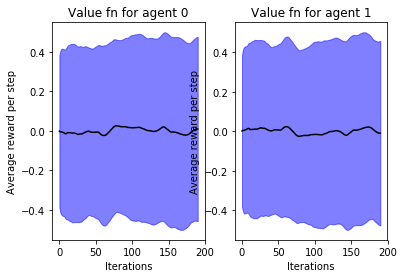

IPD nl_vs_nl


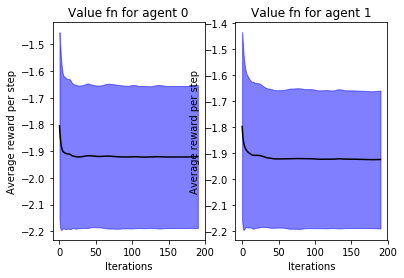

IMP lola1_vs_lola1


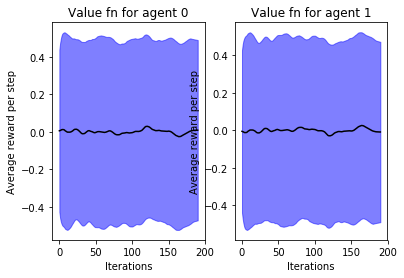

IPD lola1_vs_lola1


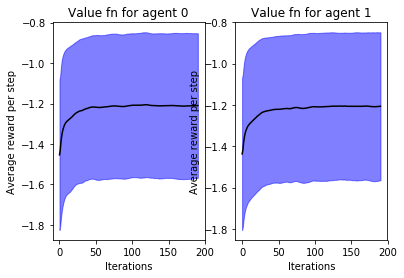

In [9]:
for filename, X in results.items():
    game = filename.split(folder)[1].split("/")[0]
    pair = filename.split(folder)[1].split("/")[1]
    if game in game_order and pair in agent_pair_order:
        print(game, pair)
        plot_average_value(X)

In [7]:
import result_collection
from result_collection.collect_batch_results import *
from result_collection.helper_func import *



def viewer_friendly_pair(agent_pair="lola1b_vs_nl"):
    substitute = {"lola1": "LOLA-Ex", "lola1b": "LOLAb-Ex", "nl": "NL"}
    agents = agent_pair.split("_")
    return substitute[agents[0]] + " vs " + substitute[agents[2]]


folder="test_results/"
results = load_results(folder + "lola1_vs_lola1_IPD.json")
print(results.keys())
agent_pair_order = [ "lola1_vs_lola1"]
#                     , "lola1_vs_nl", "lola1b_vs_nl", "lola1b_vs_lola1", "lola1b_vs_lola1b"]

game_order = ["IPD"] # "ISH", "ISD",

comparison_policies = {"IPD": [[1, 1, 0, 1, 0], [1, 1, 1, 0, 0]] }
#                        "ISH": [[1, 1, 0, 1, 0], [1, 1, 1, 0, 0]],
#                        "ISD": [[1, 1, 0, 1, 0], [1, 1, 1, 0, 0]],
#                        "IMP": [[0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5]]}

tolerances = {"IPD": 0.5,
              "ISH": 0.5,
              "ISD": 0.5,
              "IMP": 0.25}

# storing [R std %compare] for two players, for all pairs and games
table = np.zeros((len(agent_pair_order), len(game_order), 2, 3))*0.0

for filename, X in results.items():
    game = game_order[0] #filename.split(folder)[1].split("/")[0]
    pair = agent_pair_order[0] #filename.split(folder)[1].split("/")[1]
    if game in game_order and pair in agent_pair_order:
        game_idx = game_order.index(game)
        pair_idx = agent_pair_order.index(pair)

        av_R1, std_R1, av_R2, std_R2, av_compare_1, av_compare_2 = \
            get_av_ith_R_std_TFT(X, 50, comparison_policies[game], tolerances[game])

        for i, v in enumerate([av_R1, std_R1, av_compare_1]):
            table[pair_idx][game_idx][0][i] = v

        for i, v in enumerate([av_R2, std_R2, av_compare_2]):
            table[pair_idx][game_idx][1][i] = v

# Player 1 only table
csv = ""
for p, pair_result in enumerate(table):
    csv += "\n" + viewer_friendly_pair(agent_pair_order[p])
    for g, game_result in enumerate(pair_result):
        av_R1 = table[p][g][0][0]
        std_R1 = table[p][g][0][1]
        av_compare_1 = table[p][g][0][2]
        csv += ", {2:0.1f}, {0:0.2f}({1:0.2f})".format(av_R1, std_R1, av_compare_1*100)

top_row = ""
for game in game_order:
    top_row += " , " + game + ", "
top_row += ""
csv = top_row + csv
print(csv.replace(", ", " & "))

Loading... test_results/lola1_vs_lola1_IPD.json
dict_keys(['results', 'config'])


KeyError: 'config'